In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set_style("darkgrid")
sns.set_context("talk")

In [3]:
def fig_number_gen():
    """generator that will yield 0 to inf    
    """
    num = 0
    while True:
        yield num
        num += 1


fig_num = fig_number_gen()

In [4]:
# loading time-series data
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv"
)
print(df.head())
print(df.info())

# set ds as the time index
df.index = pd.to_datetime(df["ds"])
df = df.drop(columns="ds")

print(df.head())
print(df.info())

           ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      2905 non-null   object 
 1   y       2905 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.5+ KB
None
                   y
ds                  
2007-12-10  9.590761
2007-12-11  8.519590
2007-12-12  8.183677
2007-12-13  8.072467
2007-12-14  7.893572
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2905 entries, 2007-12-10 to 2016-01-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2905 non-null   float64
dtypes: float64(1)
memory usage: 45.4 KB
None


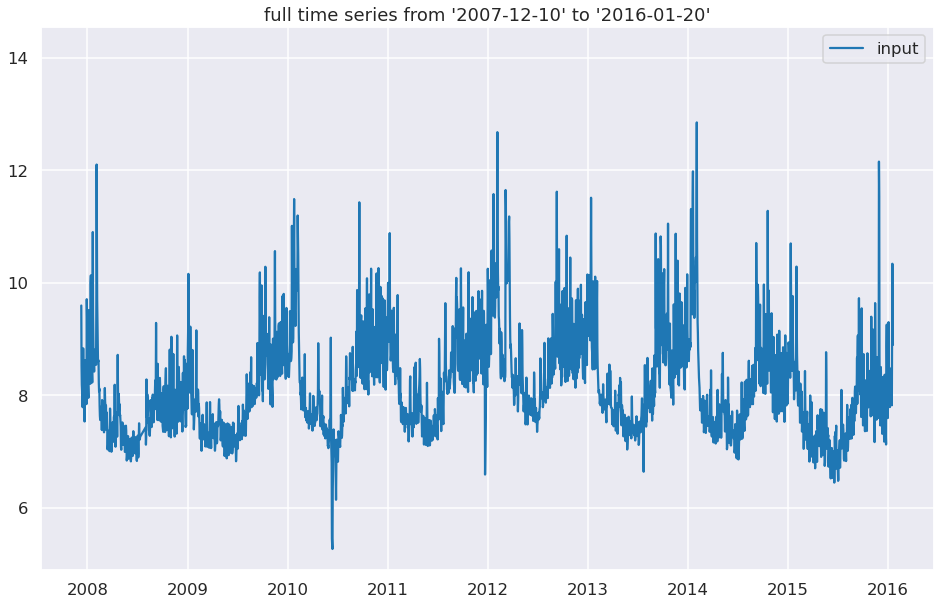

In [5]:
plt.figure(figsize=(16, 10))
plt.plot_date(x=df.index, y=df, fmt="-", label="input")
plt.legend()
plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%
plt.title(
    f"full time series from {df.index[0]:'%Y-%m-%d'} to {df.index[-1]:'%Y-%m-%d'}"
)
plt.savefig(f"figs/{next(fig_num)}_full_time_series.png")
plt.show();

In [17]:
# subsetting the data
df_sub = df.loc["01-01-2011":"31-12-2014"]
df_test = df.loc["31-12-2014":]

No handles with labels found to put in legend.


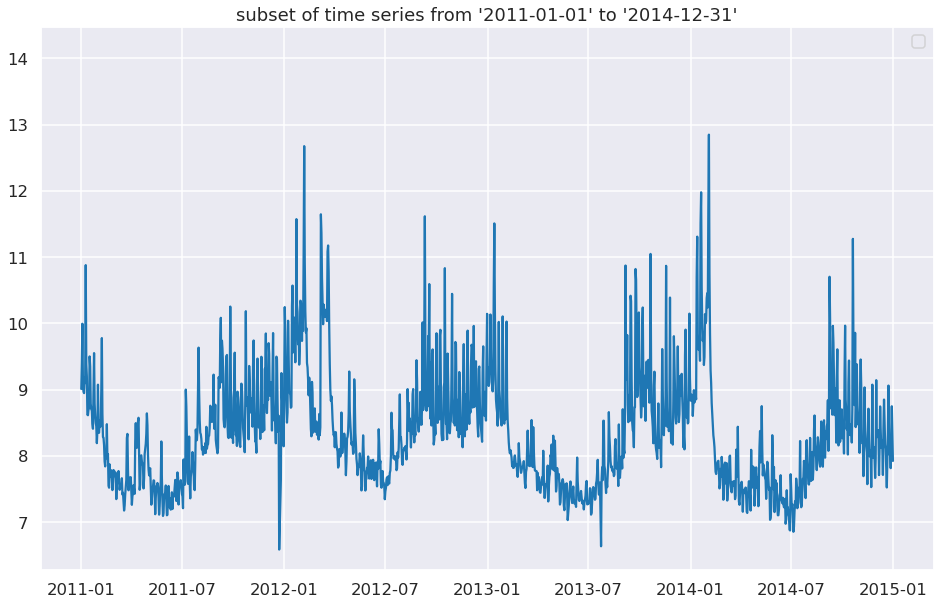

In [7]:
plt.figure(figsize=(16, 10))
plt.plot_date(
    x=df_sub.index, y=df_sub, fmt="-",
)
plt.legend()
plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%
plt.title(
    f"subset of time series from {df_sub.index[0]:'%Y-%m-%d'} to {df_sub.index[-1]:'%Y-%m-%d'}"
)
plt.savefig(f"figs/{next(fig_num)}_subset_time_series.png")
plt.show();

In [8]:
# convert the datetime to floats
time_scaler = MinMaxScaler()

# shape the inputs
X = time_scaler.fit_transform(df.index.values.reshape(-1, 1))
y = df.values.reshape(-1, 1)

# fit the lin reg
reg = LinearRegression().fit(X, y)

In [9]:
# predict using the dates of the original time series
predict_time_range = pd.date_range(start=df_sub.index[0], end=df.index[-1], freq="D")
X_predict = time_scaler.transform(predict_time_range.values.reshape(-1, 1))
y_predict = reg.predict(X_predict)

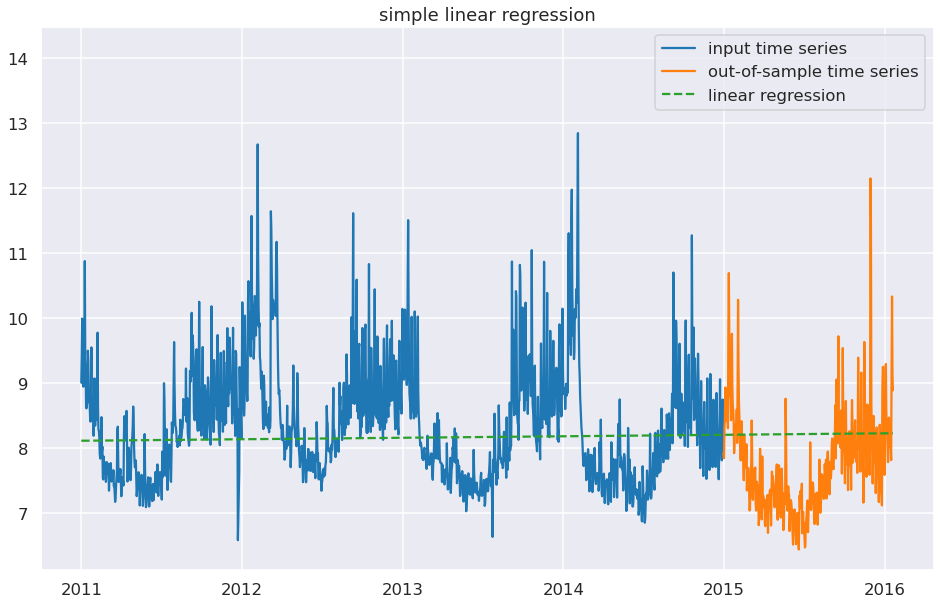

In [19]:
# plot the subset with
plt.figure(figsize=(16, 10))
plt.plot_date(x=df_sub.index, y=df_sub["y"], fmt="-", label="input time series")
plt.plot_date(x=df_test.index, y=df_test["y"], fmt="-", label="out-of-sample time series")
plt.plot_date(x=predict_time_range, y=y_predict, fmt="--", label="linear regression")
plt.legend()
plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%
plt.title("simple linear regression")
plt.savefig(f"figs/{next(fig_num)}_subset_time_series_w_linreg.png")
plt.show();

In [11]:
print(reg.intercept_)
print(reg.coef_)

[8.04539627]
[[0.18513337]]


In [12]:
df_sub.loc[:, "month"] = df_sub.index.month.values

/home/joost/miniconda3/envs/lin_frcst/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/joost/miniconda3/envs/lin_frcst/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
df_sub.sample(n=6)

,y,month
ds,,
2011-01-01,9.009692,1
2011-01-20,8.682199,1
2013-01-25,8.536211,1
2013-07-16,7.626083,7
2013-02-04,10.026192,2
2014-07-10,7.656810,7


In [14]:
df_month = pd.get_dummies(df_sub, columns=["month"], dtype="bool")
print(df_month.sample(n=6))
print(df_month.info())

                   y  month_1  month_2  month_3  month_4  month_5  month_6  \
ds                                                                           
2013-04-12  7.701200    False    False    False     True    False    False   
2012-06-11  7.633370    False    False    False    False    False     True   
2012-07-25  8.122371    False    False    False    False    False    False   
2011-03-01  7.750615    False    False     True    False    False    False   
2012-03-01  8.395477    False    False     True    False    False    False   
2013-12-23  9.904687    False    False    False    False    False    False   

            month_7  month_8  month_9  month_10  month_11  month_12  
ds                                                                   
2013-04-12    False    False    False     False     False     False  
2012-06-11    False    False    False     False     False     False  
2012-07-25     True    False    False     False     False     False  
2011-03-01    False    Fa